In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_distribution(p1_probs, p2_probs, p3_probs):
    """
    使用散点图+小提琴图展示概率分布
    
    Args:
        p1_probs: TIS非0概率值列表
        p2_probs: TTS非0概率值列表
        p3_probs: Non-TIS/TTS非1概率值列表
    """
    plt.figure(figsize=(12, 6))
    
    # 准备数据
    data = [p1_probs, p2_probs, p3_probs]
    positions = [1, 2, 3]
    colors = ['red', 'blue', 'gray']
    labels = ['TIS\nnon-zero', 'TTS\nnon-zero', 'Non-TIS/TTS\nnon-one']
    
    # 绘制小提琴图
    parts = plt.violinplot(data, positions, points=100, showmeans=True, 
                          showextrema=True, showmedians=True)
    
    # 设置小提琴图的颜色
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.3)
    
    # 设置其他小提琴图元素的颜色
    parts['cmeans'].set_color('black')
    parts['cmedians'].set_color('black')
    parts['cbars'].set_color('black')
    parts['cmins'].set_color('black')
    parts['cmaxes'].set_color('black')
    
    # 添加散点图（使用抖动效果避免重叠）
    for i, (d, pos, color) in enumerate(zip(data, positions, colors)):
        # 为散点添加随机抖动
        x = np.random.normal(pos, 0.04, size=len(d))
        plt.scatter(x, d, c=color, alpha=0.2, s=5)
    
    # 设置图表样式
    plt.title('Distribution of Non-zero/Non-one Probabilities')
    plt.ylabel('Probability')
    plt.grid(True, axis='y', alpha=0.3)
    plt.xticks(positions, labels)
    
    # 添加统计信息
    stats_text = (
        f"Statistics (mean ± std):\n"
        f"TIS: {np.mean(p1_probs):.4f} ± {np.std(p1_probs):.4f} (n={len(p1_probs)})\n"
        f"TTS: {np.mean(p2_probs):.4f} ± {np.std(p2_probs):.4f} (n={len(p2_probs)})\n"
        f"Non-TIS/TTS: {np.mean(p3_probs):.4f} ± {np.std(p3_probs):.4f} (n={len(p3_probs)})"
    )
    plt.figtext(0.15, 0.02, stats_text, fontsize=8)
    
    # 调整布局
    plt.subplots_adjust(bottom=0.2)
    plt.show()

def analyze_transcript_probabilities(pkl_file, target_id=None, num_transcripts=None, plot_type='both'):
    """
    Analyze and visualize prediction probabilities for transcripts.
    
    Args:
        pkl_file (str): Path to the pickle file containing predictions
        target_id (str, optional): Target transcript ID to analyze. Defaults to None.
        num_transcripts (int, optional): Number of transcripts to analyze when target_id is None.
        plot_type (str): Type of plot to generate ('prob', 'box', or 'both'). Defaults to 'both'.
    """
    # 验证输入参数
    if plot_type not in ['prob', 'box', 'both']:
        raise ValueError("plot_type must be 'prob', 'box', or 'both'")
        
    # 读取预测结果
    with open(pkl_file, 'rb') as f:
        predictions = pickle.load(f)
    
    # 创建列表来存储概率值
    p1_probs = []  # TIS非0概率值
    p2_probs = []  # TTS非0概率值
    p3_probs = []  # Non-TIS/TTS非1概率值
    
    n = 0
    found_target = False
    
    for item in predictions:
        # 如果指定了target_id，只处理目标转录本
        if target_id is not None:
            if item['transcript_id'] == target_id:
                found_target = True
                for i,probs in enumerate(item['predictions_probs']):
                    if probs[2] <0.95:
                        print(i,probs)
            else:
                continue
                
        # 获取概率数据
        probs_array = np.array(item['predictions_probs'])
        positions = np.arange(len(probs_array))
        
        # 收集概率值
        p1_probs.extend(probs_array[:, 0][probs_array[:, 0] > 0.01])
        p2_probs.extend(probs_array[:, 1][probs_array[:, 1] > 0.01])
        p3_probs.extend(probs_array[:, 2][probs_array[:, 2] < 0.99])
        
        # 绘制概率图
        if plot_type in ['prob', 'both']:
            plt.figure(figsize=(15, 6))
            plt.scatter(positions, probs_array[:, 0], color='red', s=2, alpha=0.7, label='TIS')
            plt.scatter(positions, probs_array[:, 1], color='blue', s=2, alpha=0.7, label='TTS')
            plt.scatter(positions, probs_array[:, 2], color='gray', s=2, alpha=0.7, label='Non-TIS/TTS')
            
            plt.title(f'Prediction Probabilities for {item["transcript_id"]}')
            plt.xlabel('Sequence Position')
            plt.ylabel('Probability')
            plt.legend()
            plt.ylim(-0.05, 1.05)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # 计数器增加
        n += 1
        
        # 检查是否达到目标数量
        if target_id is None and num_transcripts is not None and n >= num_transcripts:
            break
            
        # 如果找到了目标转录本，退出循环
        if target_id is not None and found_target:
            break
    
    # 如果指定了target_id但未找到，提示错误
    if target_id is not None and not found_target:
        print(f"Transcript {target_id} not found in predictions")
        return
    
    # 绘制箱线图
    if plot_type in ['box', 'both']:
        plot_distribution(p1_probs, p2_probs, p3_probs)


In [2]:
# 使用示例
pkl_NR_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NR_matching_predictions.pkl"
pkl_NR_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NR_non_matching_predictions.pkl"
pkl_NM_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NM_matching_predictions.pkl"
pkl_NM_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NM_non_matching_predictions.pkl"

pkl_v2_NR_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NR_matching_predictions.pkl"
pkl_v2_NR_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NR_non_matching_predictions.pkl"
pkl_v2_NM_match = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NM_matching_predictions.pkl"
pkl_v2_NM_nonMatch = "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_v2_batch4_NM_non_matching_predictions.pkl"

# 示例1：分析单个转录本，显示所有图
#analyze_transcript_probabilities(pkl_file, target_id="NR_182758", plot_type='both')
# 示例2：分析前50个转录本，只显示概率图
#analyze_transcript_probabilities(pkl_file, target_id=None, num_transcripts=50, plot_type='prob')

# 示例3：分析前100个转录本，只显示箱线图
'''
analyze_transcript_probabilities(pkl_NR_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_NM_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NR_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NM_match, target_id=None, num_transcripts=2000, plot_type='box')
analyze_transcript_probabilities(pkl_v2_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')
'''

"\nanalyze_transcript_probabilities(pkl_NR_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_NM_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NR_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NR_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NM_match, target_id=None, num_transcripts=2000, plot_type='box')\nanalyze_transcript_probabilities(pkl_v2_NM_nonMatch, target_id=None, num_transcripts=2000, plot_type='box')\n"

225 [8.3163112e-02 1.5784327e-04 9.1667908e-01]
226 [6.7714915e-02 1.5720996e-04 9.3212783e-01]
227 [7.1120270e-02 9.9756020e-05 9.2877996e-01]
978 [3.5538408e-06 3.6945963e-01 6.3053685e-01]
979 [1.1328897e-06 4.5614251e-01 5.4385638e-01]
980 [2.0371883e-06 3.1934887e-01 6.8064910e-01]


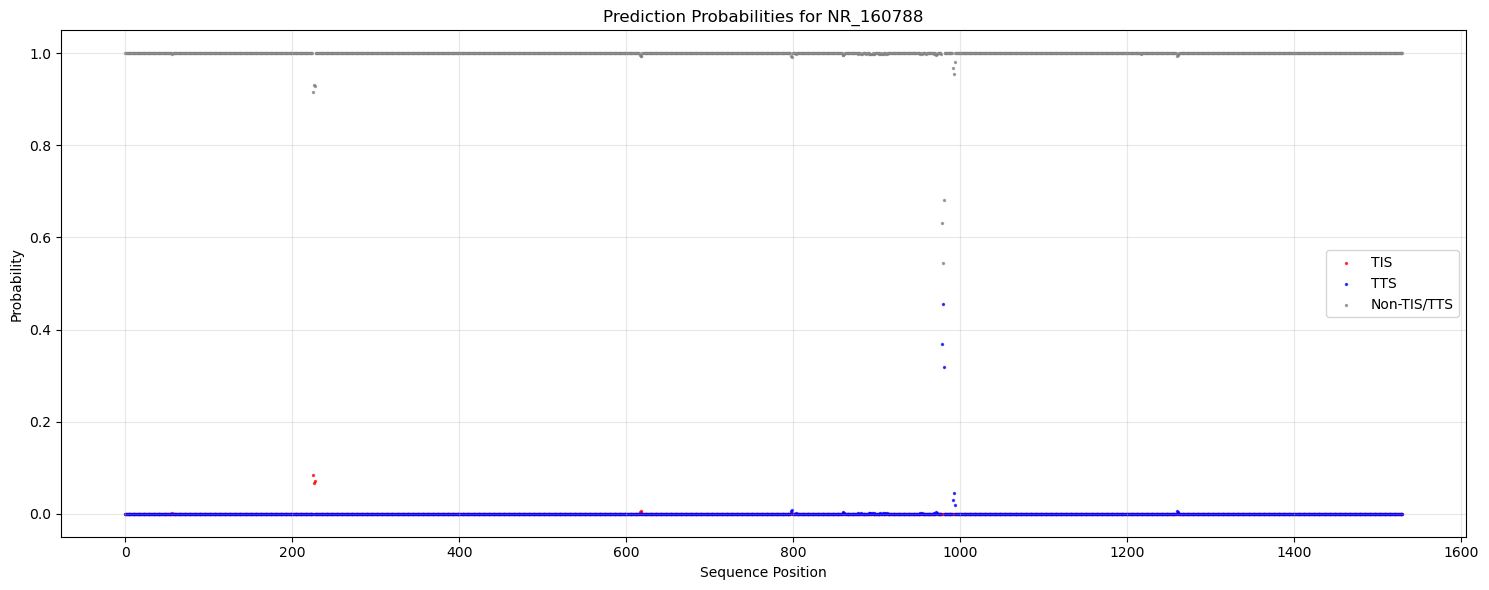

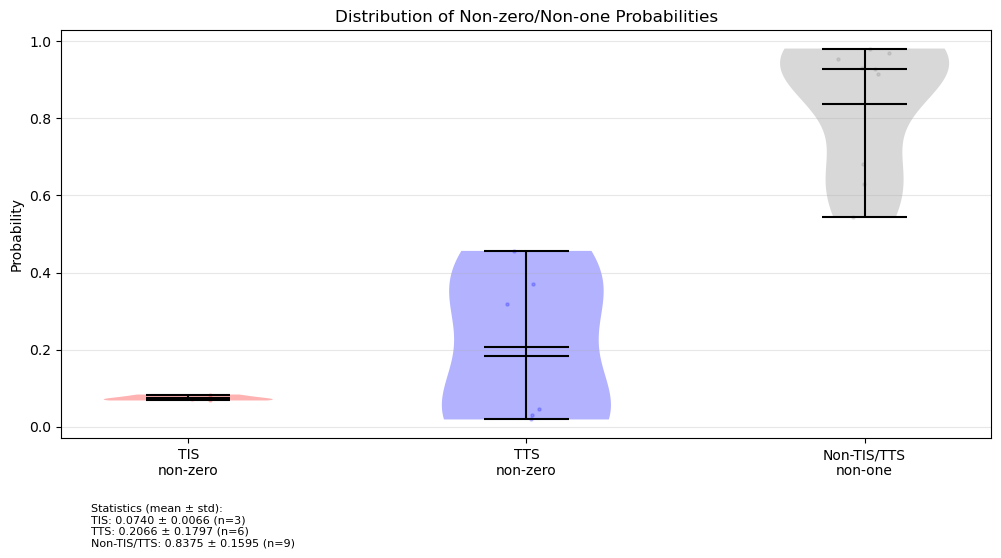

In [68]:

# 示例1：分析单个转录本，显示所有图
analyze_transcript_probabilities(pkl_NR_match, target_id="NR_160788", plot_type='both')

In [16]:
from Bio import SeqIO
from collections import defaultdict
import re

def find_non_aug_transcripts(gbff_file):
    """
    Parse GRCh38 RNA gbff file to find transcripts with non-AUG start codons.
    
    Args:
        gbff_file (str): Path to the gbff file
    
    Returns:
        list: List of dictionaries containing information about non-AUG transcripts
    """
    non_aug_transcripts = []
    codon_counts = defaultdict(int)
    
    # Parse GenBank file
    for record in SeqIO.parse(gbff_file, "genbank"):
        transcript_id = record.id
        
        for feature in record.features:
            if feature.type == "CDS":
                # Get coding sequence location
                if isinstance(feature.location, str):
                    continue
                    
                start_pos = int(feature.location.start)
                end_pos = int(feature.location.end)
                
                # Extract the start codon
                start_codon = str(record.seq[start_pos:start_pos+3]).upper()
                
                # Check if it's a non-AUG start codon
                if start_codon != "ATG":
                    # Collect relevant information
                    info = {
                        "transcript_id": transcript_id,
                        "start_codon": start_codon,
                        "position": start_pos + 1,  # 1-based position
                        "gene_name": feature.qualifiers.get("gene", ["Unknown"])[0],
                        "protein_id": feature.qualifiers.get("protein_id", ["Unknown"])[0]
                    }
                    
                    # Get product information if available
                    if "product" in feature.qualifiers:
                        info["product"] = feature.qualifiers["product"][0]
                    
                    non_aug_transcripts.append(info)
                    codon_counts[start_codon] += 1
    
    return non_aug_transcripts, codon_counts

def write_results(transcripts, counts, output_file):
    """
    Write results to a tab-delimited file.
    """
    with open(output_file, 'w') as f:
        # Write header
        f.write("Transcript_ID\tGene_Name\tStart_Codon\tPosition\tProtein_ID\tProduct\n")
        
        # Write transcript information
        for t in transcripts:
            product = t.get("product", "Unknown")
            f.write(f"{t['transcript_id']}\t{t['gene_name']}\t{t['start_codon']}\t"
                   f"{t['position']}\t{t['protein_id']}\t{product}\n")
        
        # Write summary statistics
        f.write("\n\nStart Codon Usage Summary:\n")
        for codon, count in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            f.write(f"{codon}: {count}\n")

def main():
    # File paths
    input_file = "/home/jovyan/work/insilico_translation/dataset/GRCh38_latest_rna.gbff"
    output_file = "/home/jovyan/work/insilico_translation/dataset/non_aug_transcripts.txt"
    
    print("Analyzing transcripts for non-AUG start codons...")
    non_aug_transcripts, codon_counts = find_non_aug_transcripts(input_file)
    
    print(f"Found {len(non_aug_transcripts)} transcripts with non-AUG start codons")
    print("\nStart codon distribution:")
    for codon, count in sorted(codon_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{codon}: {count}")
    
    write_results(non_aug_transcripts, codon_counts, output_file)
    print(f"\nResults have been written to {output_file}")

if __name__ == "__main__":
    main()

Analyzing transcripts for non-AUG start codons...
Found 112 transcripts with non-AUG start codons

Start codon distribution:
CTG: 67
GTG: 10
ATA: 6
TTG: 5
CCA: 5
ATT: 4
ACG: 3
CCC: 3
TGG: 1
TGC: 1
AAC: 1
GCC: 1
TAT: 1
TTT: 1
AGA: 1
ACT: 1
CTT: 1

Results have been written to /home/jovyan/work/insilico_translation/dataset/non_aug_transcripts.txt



Test values:
GC content: 0.41 -> Score: 0.990
GC content: 0.35 -> Score: 0.846
GC content: 0.45 -> Score: 0.990
GC content: 0.30 -> Score: 0.619
GC content: 0.50 -> Score: 0.881


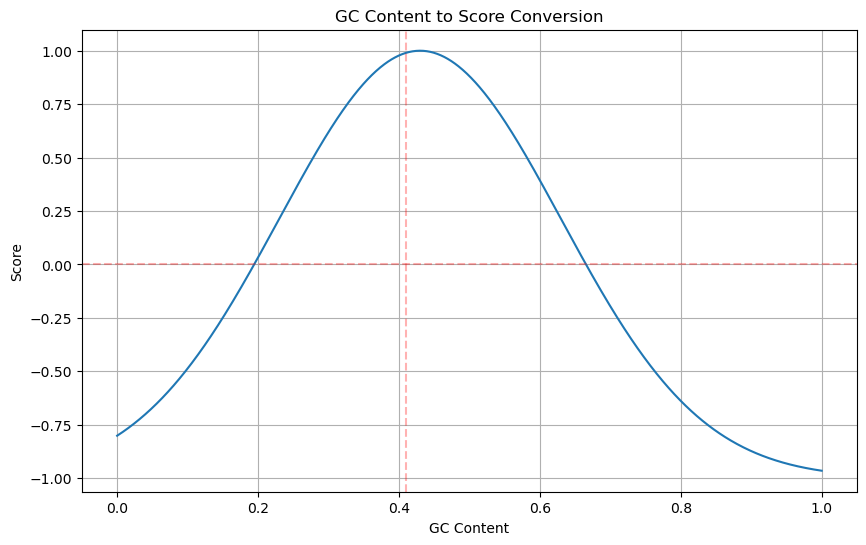

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def gc_to_score(gc_content, mean_gc=0.43, std_gc=0.2):
    """
    将GC含量转换为-1到1之间的得分
    
    参数:
    gc_content: float or numpy array, GC含量值
    mean_gc: float, GC含量的期望值（默认0.41）
    std_gc: float, GC含量的标准差（可调整，控制曲线陡峭程度）
    
    返回:
    float or numpy array: 转换后的得分
    """
    # 使用高斯函数变换
    score = 2 * np.exp(-0.5 * ((gc_content - mean_gc) / std_gc) ** 2) - 1
    return score

# 测试和可视化
if __name__ == "__main__":
    # 生成测试数据
    gc_values = np.linspace(0, 1, 1000)
    scores = gc_to_score(gc_values)
    
    # 绘制转换曲线
    plt.figure(figsize=(10, 6))
    plt.plot(gc_values, scores)
    plt.grid(True)
    plt.xlabel('GC Content')
    plt.ylabel('Score')
    plt.title('GC Content to Score Conversion')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    plt.axvline(x=0.41, color='r', linestyle='--', alpha=0.3)
    
    # 测试一些具体值
    test_values = [0.41, 0.35, 0.45, 0.3, 0.5]
    print("\nTest values:")
    for gc in test_values:
        score = gc_to_score(gc)
        print(f"GC content: {gc:.2f} -> Score: {score:.3f}")
    
    plt.show()